# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 4)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents (Part 4)
5. [Model Development: Recurrent Neural Networks](#model)  
  5.4. [Recurrent Neural Network with Regularization Techniques](#regularized)
6. [Results](#results)  
7. [Discussion](#discussion)  
8. [Conclusion](#conclusion)  
  8.1. [Project Summary](#summary)  
  8.2. [Outcome of the Analysis](#outcome)  
  8.3. [Potential Developments](#developments)

*Import the training data, the testing data, and the vocabulary word index from the Keras Tokenizer.*

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
x_train_pad = pd.read_csv('x_train_pad.csv', index_col=False).values
x_test_pad = pd.read_csv('x_test_pad.csv', index_col=False).values
y_train = pd.read_csv('y_train.csv', index_col=False)
y_test = pd.read_csv('y_test.csv', index_col=False)

In [3]:
with open('word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

## 5. Model Development: Recurrent Neural Networks <a name= 'model'></a>

In [10]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding
from keras import optimizers
from numpy.random import seed
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint

### 5.4. Recurrent Neural Network with Regularization Techniques <a name='regularized'></a>

Learning the word embeddings from scratch proved to be the best option in terms of model's accuracy, calculated on unseen data.  
All trained models, however, have a common issue: the ovefitting. All networks, regardless of the used word embeddings, fits the training data very well, achieving 100% training accuracy after few epochs; however, the acccuracy, calculated on the validation set, seems unable to exceed the 65% threshold:
- Learn the word embeddings from scratch: 65% accuracy
- Pre-trained GloVe Word Embeddings: 64% accuracy
- Pre-trained Google News Word2Vec Word Embeddings: 60% accurancy

I'll try to increase the out-of-sample accuracy by building a last model: learning the word embeddings from scratch and using some **regularization techniques**, in order to decrease the variance of the model. This should lead to a "simpler" model, where the predictions are less sensitive to changes in the input data, and so, hopefully, increasing the ability of the model to "generalize" better when making predictions, that is to better capture the underlying relationships between the target and the predictor, without following too much the noise present in the training data; this will, almost certainly, lead to a lower training accurancy, but the hope is that that validation accuracy will increase.  
I'll use the following regularization techniques:
- **L2 Regularization Penalty** for the Embedding and the Recurrent Neural Network layers. This means that the sum of the squares of the parameters (for the Recurrent Neural Network, the penalty is considered for both the bias, the Kernel, and the Recurrent weights) will be added to the model loss, thus forcing the model to keep the parameter values smaller (and so reducing the sensitivity to the input data).
- Using the **Keras constraint Max Norm** for all model layers. The Max Norm constraint forces the model weights to have a magnitude less than or equal to a certain value, which will be set to 1 for all layers.

In [8]:
seed(1)
tf.random.set_seed(1)

#Initialize the model
reg_rnn = Sequential()
reg_rnn.add(Embedding(len(word_index.items())+1, output_dim=300, trainable=True, embeddings_regularizer='l2',
                      embeddings_constraint=max_norm(1)))

reg_rnn.add(SimpleRNN(units=150, activation='tanh', input_shape=x_train_pad.shape[1:], kernel_regularizer='l2',
                      recurrent_regularizer='l2', bias_regularizer='l2', kernel_constraint=max_norm(1),
                      recurrent_constraint=max_norm(1), bias_constraint=max_norm(1)))

reg_rnn.add(Dense(1, activation='sigmoid', kernel_constraint=max_norm(1), bias_constraint=max_norm(1)))

adam = optimizers.Adam(learning_rate=0.001)
reg_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

reg_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         4726500   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150)               67650     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


The number of parameters is unchanged.

In [11]:
#set Keras Model Checkpoint callback to save the weights when the model is at its best performance
mcp=ModelCheckpoint('reg_best_weights.hdf5', monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True,
                    save_freq="epoch")

hist=reg_rnn.fit(x_train_pad, y_train, batch_size=16, epochs=25, shuffle=True, validation_data=(x_test_pad, y_test),
                 callbacks=[mcp])

Epoch 1/25
25/25 [==============================] - 7s 190ms/step - loss: 5.5910 - accuracy: 0.5675 - val_loss: 2.8658 - val_accuracy: 0.6100
Epoch 2/25
25/25 [==============================] - 5s 191ms/step - loss: 2.4327 - accuracy: 0.7275 - val_loss: 2.0865 - val_accuracy: 0.5900
Epoch 3/25
25/25 [==============================] - 4s 154ms/step - loss: 1.8353 - accuracy: 0.6600 - val_loss: 1.6587 - val_accuracy: 0.5900
Epoch 4/25
25/25 [==============================] - 4s 168ms/step - loss: 1.5254 - accuracy: 0.5900 - val_loss: 1.4928 - val_accuracy: 0.5900
Epoch 5/25
25/25 [==============================] - 5s 188ms/step - loss: 1.3717 - accuracy: 0.5850 - val_loss: 1.2921 - val_accuracy: 0.5900
Epoch 6/25
25/25 [==============================] - 4s 147ms/step - loss: 1.1976 - accuracy: 0.5850 - val_loss: 1.1630 - val_accuracy: 0.5900
Epoch 7/25
25/25 [==============================] - 4s 150ms/step - loss: 1.1077 - accuracy: 0.6075 - val_loss: 1.1917 - val_accuracy: 0.5700
Epoch 

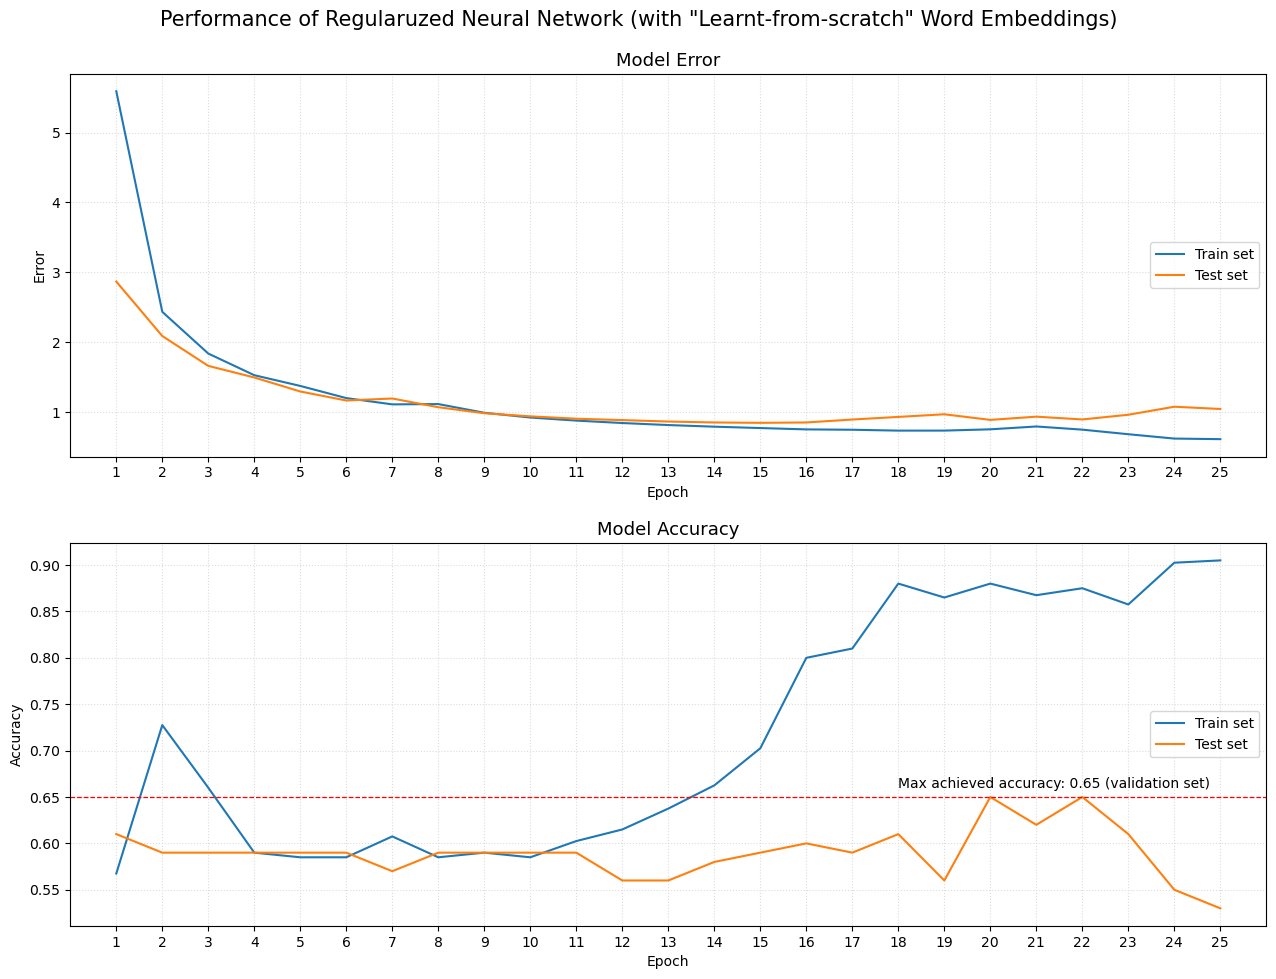

In [16]:
fig = plt.figure(figsize=(13,10))
loss = fig.add_subplot(2,1,1) 
accuracy = fig.add_subplot(2,1,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticks(range(0,25))
accuracy.set_xticklabels(range(1,26))
accuracy.set_xlim(-1,25)
accuracy.legend(['Train set', 'Test set'], loc='center right')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
accuracy.axhline(y=0.65, color='r', lw=0.9, ls='--')
accuracy.annotate('Max achieved accuracy: 0.65 (validation set)', xy=(17,0.66))

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticks(range(0,25))
loss.set_xticklabels(range(1,26))
loss.set_xlim(-1,25)
loss.legend(['Train set', 'Test set'], loc='center right')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Performance of Regularuzed Neural Network (with "Learnt-from-scratch" Word Embeddings)', fontsize=15)
plt.tight_layout(pad=1.5)
plt.show()

In [35]:
val_acc = hist.history['val_accuracy']
val_acc.index(max(va_acc))

19

In [101]:
seed(1)
tf.random.set_seed(1)

#Initialize the model
plain_rnn_2 = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#I am not using any pre-trained embeddings
plain_rnn_2.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True, embeddings_regularizer='l2',
                        embeddings_constraint=max_norm(3)))

# Add the RNN layer
plain_rnn_2.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:], kernel_regularizer='l2', recurrent_regularizer='l2',
                        bias_regularizer='l2', kernel_constraint=max_norm(4), recurrent_constraint=max_norm(4),
                        bias_constraint=max_norm(4)))

# Add the final output layer
plain_rnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
plain_rnn_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
plain_rnn_2.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 300)         4726500   
                                                                 
 simple_rnn_21 (SimpleRNN)   (None, 150)               67650     
                                                                 
 dense_21 (Dense)            (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Train the model with early stopping to get best results
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=7)
hist=plain_rnn_2.fit(x_train_pad,y_train,batch_size=16,epochs=50,shuffle=True,validation_data=(x_test_pad,y_test),
                     callbacks=[es])

Epoch 1/50
25/25 [==============================] - 6s 147ms/step - loss: 17.9046 - accuracy: 0.5375 - val_loss: 7.2088 - val_accuracy: 0.4000
Epoch 2/50
25/25 [==============================] - 4s 160ms/step - loss: 4.4992 - accuracy: 0.7125 - val_loss: 3.0629 - val_accuracy: 0.5900
Epoch 3/50
25/25 [==============================] - 4s 163ms/step - loss: 2.5866 - accuracy: 0.6600 - val_loss: 2.3339 - val_accuracy: 0.5800
Epoch 4/50
25/25 [==============================] - 4s 144ms/step - loss: 2.0468 - accuracy: 0.9250 - val_loss: 2.0835 - val_accuracy: 0.5800
Epoch 5/50
25/25 [==============================] - 4s 179ms/step - loss: 1.7776 - accuracy: 0.9250 - val_loss: 1.9704 - val_accuracy: 0.5900
Epoch 6/50
25/25 [==============================] - 4s 148ms/step - loss: 1.7797 - accuracy: 0.8375 - val_loss: 2.1202 - val_accuracy: 0.5000
Epoch 7/50
25/25 [==============================] - 4s 142ms/step - loss: 1.8548 - accuracy: 0.9100 - val_loss: 2.0704 - val_accuracy: 0.5800
Epoch

## Results

**Regularized Model**

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

In [41]:
y_pred = plain_rnn.predict(x_test_pad)

4/4 [==============================] - 1s 27ms/step


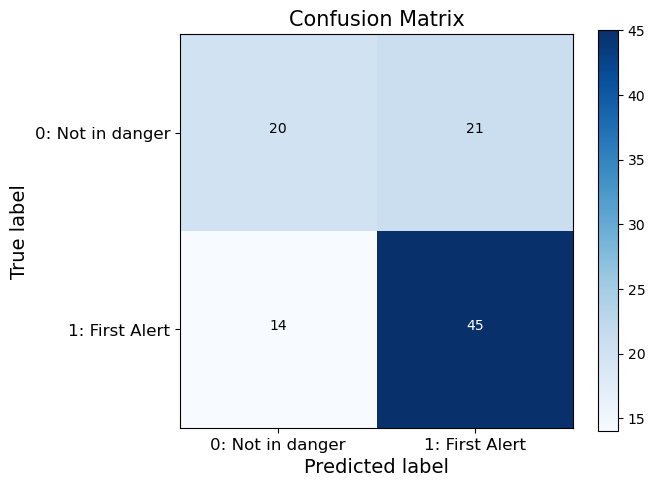

In [42]:
#Define a function for better visualization of Confusion Matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    

reg_rnn_cm = confusion_matrix(y_test, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [43]:
print('Classification Report')
print(classification_report(y_test, (y_pred >= .5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, y_pred),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       0.59      0.49      0.53        41
  First Alert       0.68      0.76      0.72        59

     accuracy                           0.65       100
    macro avg       0.64      0.63      0.63       100
 weighted avg       0.64      0.65      0.64       100

ROC - Area Under the Curve:  0.65


In [119]:
y_pred = plain_rnn_2.predict(x_train_pad)

13/13 [==============================] - 0s 27ms/step


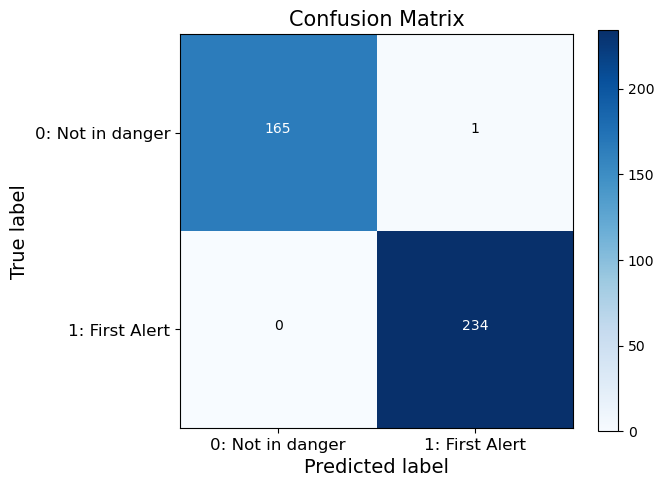

In [120]:
reg_rnn_cm = confusion_matrix(y_train, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [126]:
print('Classification Report')
print(classification_report(y_train, (y_pred>=.5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_train, (y_pred>=.5).astype('int')),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       1.00      0.99      1.00       166
  First Alert       1.00      1.00      1.00       234

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

ROC - Area Under the Curve:  1.0


---

**Not Regularized Model**

In [128]:
seed(1)
tf.random.set_seed(1)
#Initialize the model
plain_rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 300-dimensional vector.
#I am not using any pre-trained embeddings
plain_rnn.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, trainable=True, mask_zero=False))

# Add the RNN layer
plain_rnn.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:]))

# Add the final output layer
plain_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
plain_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
plain_rnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, None, 300)         4726500   
                                                                 
 simple_rnn_22 (SimpleRNN)   (None, 150)               67650     
                                                                 
 dense_22 (Dense)            (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


In [129]:
# Train the model
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=7)
hist=plain_rnn.fit(x_train_pad,y_train,batch_size=16,epochs=10,shuffle=True,validation_data=(x_test_pad, y_test),callbacks=[es])

Epoch 1/10
25/25 [==============================] - 7s 138ms/step - loss: 0.6977 - accuracy: 0.5575 - val_loss: 0.6990 - val_accuracy: 0.5700
Epoch 2/10
25/25 [==============================] - 3s 101ms/step - loss: 0.4940 - accuracy: 0.7700 - val_loss: 0.6886 - val_accuracy: 0.5800
Epoch 3/10
25/25 [==============================] - 3s 112ms/step - loss: 0.1563 - accuracy: 0.9775 - val_loss: 0.7387 - val_accuracy: 0.5800
Epoch 4/10
25/25 [==============================] - 3s 107ms/step - loss: 0.0881 - accuracy: 0.9775 - val_loss: 1.0136 - val_accuracy: 0.5700
Epoch 5/10
25/25 [==============================] - 3s 117ms/step - loss: 0.0494 - accuracy: 0.9925 - val_loss: 0.7702 - val_accuracy: 0.5800
Epoch 6/10
25/25 [==============================] - 3s 117ms/step - loss: 0.0178 - accuracy: 0.9975 - val_loss: 1.0278 - val_accuracy: 0.5300
Epoch 7/10
25/25 [==============================] - 3s 113ms/step - loss: 0.0240 - accuracy: 0.9950 - val_loss: 1.0534 - val_accuracy: 0.5800
Epoch 

In [133]:
y_pred = plain_rnn.predict(x_test_pad)

4/4 [==============================] - 0s 21ms/step


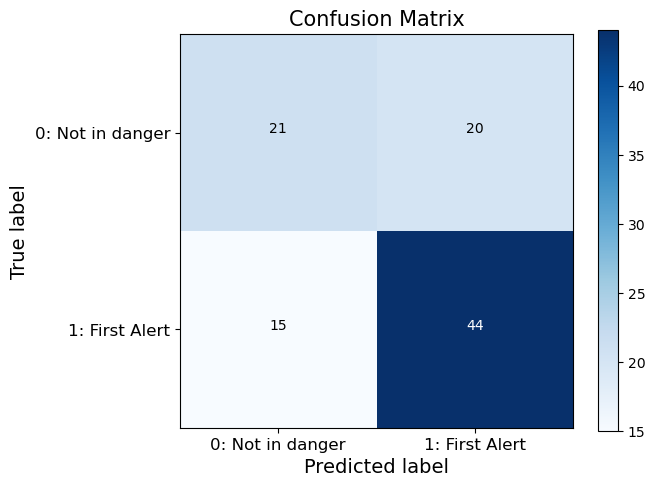

In [134]:
reg_rnn_cm = confusion_matrix(y_test, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [136]:
print('Classification Report')
print(classification_report(y_test, (y_pred >= .5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, y_pred),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       0.58      0.51      0.55        41
  First Alert       0.69      0.75      0.72        59

     accuracy                           0.65       100
    macro avg       0.64      0.63      0.63       100
 weighted avg       0.64      0.65      0.65       100

ROC - Area Under the Curve:  0.63


In [137]:
y_pred = plain_rnn.predict(x_train_pad)

13/13 [==============================] - 0s 29ms/step


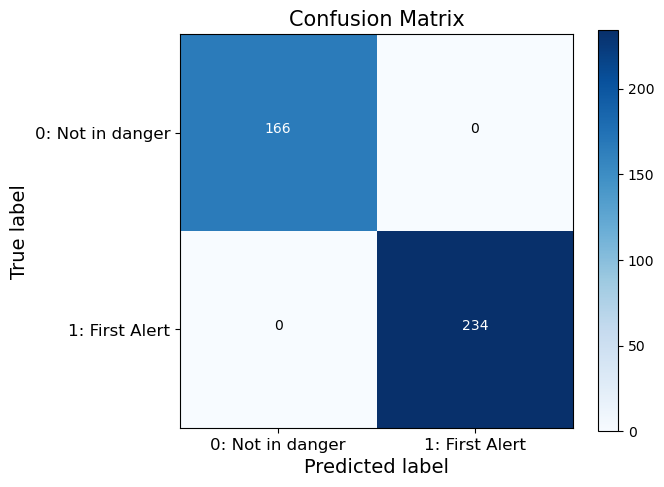

In [138]:
reg_rnn_cm = confusion_matrix(y_train, (y_pred >= .5).astype('int'), labels=[0,1])
plot_confusion_matrix(reg_rnn_cm, classes=['0: Not in danger', '1: First Alert'], title='Confusion Matrix')

In [139]:
print('Classification Report')
print(classification_report(y_train, (y_pred>=.5).astype('int'), labels=[0,1], target_names=['Not in danger', 'First Alert']))
print('ROC - Area Under the Curve: ', round(roc_auc_score(y_train, (y_pred>=.5).astype('int')),2))

Classification Report
               precision    recall  f1-score   support

Not in danger       1.00      1.00      1.00       166
  First Alert       1.00      1.00      1.00       234

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

ROC - Area Under the Curve:  1.0


---

Extras:
1. can I do cross validation / hyperparameters tuning with deep learnig models: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/#:~:text=By%20setting%20the%20n_jobs%20argument,for%20each%20combination%20of%20parameters.